# 8. Transfer Learning with TensorFlow Part 3: Scaling Up

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## What we're going to cover

* Downloading and preparing 10% of all Food101 classes (7500+ training images)
* Training a transfer learning feature extraction model
* Fine-tuning our feature extraction model (Food Vision mini) to beat the original Food101 paper with only 10% of the data
* Evaluating Food Vision mini's predictions
 - Finding the most wrong predictions (on the test dataset)
* Making predictions with Food Vision mini on our own custom images

Our goal is to beat the original Food101 papaer with 10% of the training (leveraging the power of deep learning)

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [2]:
!nvidia-smi

Fri Jul  8 03:52:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-08 03:52:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.5’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-08 03:52:13 (112 MB/s) - ‘helper_functions.py.5’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less Data

Our goal is to beat the original Food101 paper with 10% of the training data, so lets download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook

In [5]:
import zipfile
import os
# if os.path.exists('/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent.zip') == False:
!curl "https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip" --output "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent.zip"
zip_file = zipfile.ZipFile("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent.zip")
zip_file.extractall("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification")
zip_file.close()
os.remove("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent.zip")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1550M  100 1550M    0     0  83.6M      0  0:00:18  0:00:18 --:--:-- 85.4M


In [6]:
# How many images/classes are there?
walk_through_dir("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent")

There are 2 directories and 0 images in '/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories 

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_dir = "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent/train"
test_dir = "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/101_food_classes_10_percent/test"
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode = "categorical", image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode = "categorical", image_size = IMG_SIZE, shuffle = False) # don't shuffle test data for predictions

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model(we'll create our own output layer)
* Compile the model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [12]:
# Create checkpoin callback
checkpoint_path = "/content/drive/MyDrive/TensorFlow Developer Certification/Checkpoints/Classification/Transfer_Learning_Scaling_Up"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_best_only = True, monitor = "val_accuracy")

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation 
data_augmentation = Sequential(
    [
     preprocessing.RandomFlip("horizontal"),
     preprocessing.RandomZoom(0.2),
     preprocessing.RandomRotation(0.2),
     preprocessing.RandomHeight(0.2),
     preprocessing.RandomWidth(0.2),
    #  preprocessing.Recaling(1./255) # rescale inputs of images to between 0 and 1; required for models like ResNet50
    ], name = "data_augmentation_layer"
)

## Headless EfficientNetB0 Model using Functional API

In [19]:
effnet_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
effnet_model.trainable = False

# Create the input layer
inputs = tf.keras.layers.Input(shape = IMG_SIZE +(3,), name = "input_layer")

# Add in the data augmentation layer
x = data_augmentation(inputs)

# Add in the efficientnet model
x = effnet_model(x, training = False)

# Now throw in that GlobalAveragePooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pool_layer")(x)

# Finally a dense layer to get classification predictions
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)

# Now make it into a model
model = tf.keras.Model(inputs, outputs, name = "model_scaling_up")

In [20]:
model.summary()

Model: "model_scaling_up"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pool_layer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381


In [21]:
# Compile the model
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Fit the model
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.25*len(test_data)),
    callbacks = [create_tensorboard_callback("/content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification", "effnet_model_101_classes_10_pct"), checkpoint]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification/effnet_model_101_classes_10_pct/20220708-042505
Epoch 1/5
237/237 [==============================] - 66s 248ms/step - loss: 3.4740 - accuracy: 0.2487 - precision_2: 0.9618 - recall_2: 0.0199 - val_loss: 2.6201 - val_accuracy: 0.4085 - val_precision_2: 0.8700 - val_recall_2: 0.0276
Epoch 2/5
237/237 [==============================] - 56s 233ms/step - loss: 2.3486 - accuracy: 0.4606 - precision_2: 0.9237 - recall_2: 0.1246 - val_loss: 2.1790 - val_accuracy: 0.4684 - val_precision_2: 0.8797 - val_recall_2: 0.1299
Epoch 3/5
237/237 [==============================] - 52s 215ms/step - loss: 1.9771 - accuracy: 0.5294 - precision_2: 0.9147 - recall_2: 0.2095 - val_loss: 1.9970 - val_accuracy: 0.4937 - val_precision_2: 0.8475 - val_recall_2: 0.2019
Epoch 4/5
237/237 [==============================] - 52s 217ms/step - loss: 1.7621 - accuracy: 0.5714 - precision_2: 0.9077 - recall

In [18]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 92s 116ms/step - loss: 1.7135 - accuracy: 0.5535 - precision_1: 0.8480 - recall_1: 0.3364


[1.7134788036346436, 0.5535445809364319, 0.847973644733429, 0.3364356458187103]

Whoa! We seem to have already achieved our objective. And that too in just 10 minutes. This illustrates the power of deep learning.

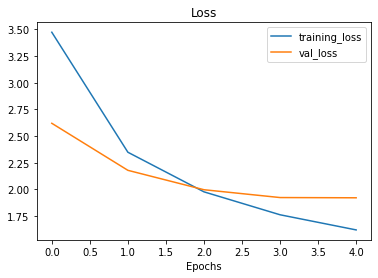

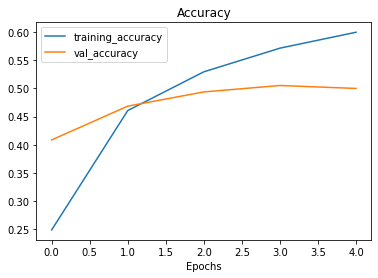

In [22]:
plot_loss_curves(history_all_classes_10_percent)

Ah but we seem to be overfitting. Where's our train data?